In [1]:
# coding: utf-8

import os
import random
import itertools

from nltk import word_tokenize
from nltk.tokenize import wordpunct_tokenize

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

In [2]:
negative = [f for f in os.listdir('./review_polarity 2/txt_sentoken/neg') if f.endswith('.txt')]

In [3]:
positive = [f for f in os.listdir('./review_polarity 2/txt_sentoken/pos') if f.endswith('.txt')]

In [4]:
arr_reviews = []

for review in negative:
    with open('./review_polarity 2/txt_sentoken/neg/' + review, 'r', encoding='utf-8') as r:
        dicti = {}
        text = r.read()
        dicti['class'] = 'negative'
        dicti['text'] = text
        arr_reviews.append(dicti)
        
for review in positive:
    with open('./review_polarity 2/txt_sentoken/pos/' + review, 'r', encoding='utf-8') as r:
        dicti = {}
        text = r.read()
        dicti['class'] = 'positive'
        dicti['text'] = text
        arr_reviews.append(dicti)

        
random.shuffle(arr_reviews)  # перемешиваем данные
    
df = pd.DataFrame(arr_reviews)  # создаем датасет


In [5]:
df.head()

,class,text
0,positive,note : some may consider portions of the follo...
1,negative,whether or not i would be considered a trekker...
2,negative,_dirty_work_ has a premise of deliciously mean...
3,positive,contact ( pg ) there's a moment late in robert...
4,negative,"hey , i've got a great idea for a movie ! \nok..."


In [6]:
df.describe()

,class,text
count,2000,2000
unique,2,2000
top,positive,i suppose it's unfair to criticize a movie lik...
freq,1000,1


In [7]:
df.groupby('class').describe()

text
class                                                             
negative count                                                1000
         unique                                               1000
         top     i suppose it's unfair to criticize a movie lik...
         freq                                                    1
positive count                                                1000
         unique                                               1000
         top     sam ( matthew broderick ) is an astronomer in ...
         freq                                                    1

In [8]:
#  Делим выборку в соотновении 80:20
rev_train, rev_test, class_train, class_test = train_test_split(df['text'], df['class'], test_size=0.2)

In [9]:
rev_train.shape, rev_test.shape, class_train.shape, class_test.shape

((1600,), (400,), (1600,), (400,))

In [10]:
# Векторизация Bag of Words
bow = CountVectorizer(stop_words='english')
bow.fit_transform(rev_train)
bowed_rev_train = bow.transform(rev_train)  # тренировочные тексты
bowed_rev_test = bow.transform(rev_test)   # тестовые тексты

Добавим удаление стоп слов, потому что это улучшает качество классификации (я проверила)

In [11]:
# Обучение DummyClassifier
dummy_bow = DummyClassifier(strategy='most_frequent', random_state=0)
dummy_bow = dummy_bow.fit(bowed_rev_train, class_train)

# Вывод результатов по Dummy Classifier
print(classification_report(class_test, dummy_bow.predict(bowed_rev_test)))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00       202
   positive       0.49      1.00      0.66       198

avg / total       0.25      0.49      0.33       400



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
# Обучаем модель логистической регрессии
logit_bow = LogisticRegression(class_weight='balanced')
logit_bow.fit(bowed_rev_train, class_train)

# Вывод результатов по Logistic Regression
print(classification_report(class_test, logit_bow.predict(bowed_rev_test)))

             precision    recall  f1-score   support

   negative       0.86      0.88      0.87       202
   positive       0.87      0.85      0.86       198

avg / total       0.86      0.86      0.86       400



In [13]:
# Векторизация TF-IDF
vectorizer = TfidfVectorizer(min_df=5,
                             max_df = 0.8,
                             sublinear_tf=True,
                             use_idf=True,
                             stop_words='english')
tfidf_rev_train = vectorizer.fit_transform(rev_train)
tfidf_rev_test = vectorizer.transform(rev_test)

In [14]:
# Обучение DummyClassifier
dummy_tfidf = DummyClassifier(strategy='most_frequent', random_state=0)
dummy_tfidf.fit(tfidf_rev_train, class_train)

# Вывод результатов по Dummy Classifier
print(classification_report(class_test, dummy_tfidf.predict(tfidf_rev_test)))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00       202
   positive       0.49      1.00      0.66       198

avg / total       0.25      0.49      0.33       400



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Наша модель справилась с определением сентимента лучше, чем DummyClassifier

In [15]:
# Обучаем модель логистической регрессии
logit_tfidf = LogisticRegression(class_weight='balanced')
logit_tfidf.fit(tfidf_rev_train, class_train)

# Печатаем результаты классификации
print(classification_report(class_test, logit_tfidf.predict(tfidf_rev_test)))

             precision    recall  f1-score   support

   negative       0.90      0.89      0.89       202
   positive       0.89      0.89      0.89       198

avg / total       0.89      0.89      0.89       400



Наша модель справилась с определением сентимента лучше, чем DummyClassifier

Линейная регрессия

y=β0+β1x

Логистическая регрессия

log(p1−p)=β0+β1x

In [16]:
# Обучаем модель Наивный Байес
naive_model = MultinomialNB()
naive_model.fit(bowed_rev_train, class_train)
print(classification_report(class_test, naive_model.predict(bowed_rev_test)))

             precision    recall  f1-score   support

   negative       0.81      0.83      0.82       202
   positive       0.82      0.81      0.81       198

avg / total       0.82      0.82      0.82       400



In [17]:
# Обучаем модель Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(bowed_rev_train, class_train)
print(classification_report(class_test, rf_model.predict(bowed_rev_test)))

             precision    recall  f1-score   support

   negative       0.65      0.81      0.72       202
   positive       0.74      0.55      0.63       198

avg / total       0.69      0.68      0.68       400



Лучше всего классифицирует алгоритм Logistic Regression с векторизацией методом BOW с показателем f-score=83%

In [18]:
logit_bow.coef_

array([[-0.02233091,  0.00631053,  0.0382658 , ...,  0.00092578,
        -0.00419321,  0.01276607]])

Положительный коэффициент обозначает, что соответствующий признак увеличивает вероятность класса. Отрицательный коэффициент обозначает, что соответствующий признак уменьшает вероятность класса. Чем больше коэффициент, тем больший вес имеет соответствующий признак. Если коэффициент равен нулю, это означает, что признак не не имеет никакого веса

In [19]:
logit_bow.intercept_

array([-0.42214073])

In [20]:
logit_bow.classes_

array(['negative', 'positive'], dtype=object)

In [25]:
logodds = logit_bow.intercept_ + logit_bow.coef_[0] * 2  # compute predicted log-odds for al=2 using the equation
odds = np.exp(logodds)  # convert log-odds to odds
prob = odds/(1 + odds)  # convert odds to probability

In [26]:
logodds

array([-0.46680254, -0.40951967, -0.34560913, ..., -0.42028918,
       -0.43052715, -0.39660859])

In [27]:
odds

array([ 0.62700388,  0.6639691 ,  0.70778909, ...,  0.65685684,
        0.65016627,  0.67259724])

In [28]:
prob

array([ 0.38537332,  0.3990273 ,  0.4144476 , ...,  0.39644755,
        0.39400046,  0.40212743])

In [29]:
# compute predicted probability for al=2 using the predict_proba method
logit_bow.predict_proba(bowed_rev_test[0])[:, 1]

array([ 0.33320533])

In [30]:
logit_bow.predict(bowed_rev_test[0])

array(['negative'], dtype=object)

In [31]:
cnf_matrix = confusion_matrix(class_test, logit_bow.predict(bowed_rev_test))
cnf_matrix

array([[177,  25],
       [ 30, 168]])

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [33]:
class_names = ['negative', 'positive']

Confusion matrix, without normalization
[[177  25]
 [ 30 168]]
Normalized confusion matrix
[[ 0.87623762  0.12376238]
 [ 0.15151515  0.84848485]]


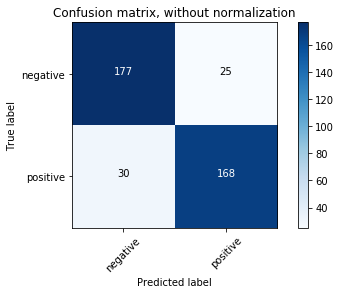

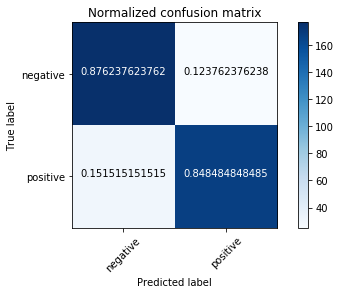

In [34]:
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Cobfusion Matrix позволяет оценить качество вывода классификатора. Элементы по диагонали показывают True Positive, то есть когда предсказанный класс совпадает с true классом. Мы видим, что процент правильных предсказаний очень высокий, значит, классификатор работает достаточно хорошо.

In [35]:
def grid_search_function(clf, parameters, X_train, X_test, y_train, y_test):
    gs = GridSearchCV(clf, parameters)
    gs.fit(X_train, y_train)
    print (gs.best_params_)
    y_pred = gs.predict(X_test)
    print(classification_report(y_test, y_pred))

In [36]:
rfc_params = {'n_estimators': [20, 40, 60],
              'max_depth': [None, 2, 4],
              'max_leaf_nodes': [None, 2, 4],
              'min_samples_leaf': [1, 2, 3],
              'criterion': ["gini", "entropy"]
             }
grid_search_function(RandomForestClassifier(), rfc_params, bowed_rev_train, bowed_rev_test, class_train, class_test)

{'n_estimators': 60, 'max_depth': None, 'min_samples_leaf': 2, 'criterion': 'entropy', 'max_leaf_nodes': None}
             precision    recall  f1-score   support

   negative       0.82      0.87      0.84       202
   positive       0.86      0.81      0.83       198

avg / total       0.84      0.84      0.84       400



In [37]:
mnb_params = {'alpha': [0, 0.5, 1],
              'fit_prior': [True, False]
             }
grid_search_function(MultinomialNB(), mnb_params, bowed_rev_train, bowed_rev_test, class_train, class_test)

/usr/local/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/usr/local/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/usr/local/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/usr/local/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/usr/local/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/usr/local/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) 

{'fit_prior': True, 'alpha': 1}
             precision    recall  f1-score   support

   negative       0.81      0.83      0.82       202
   positive       0.82      0.81      0.81       198

avg / total       0.82      0.82      0.82       400



In [38]:
lg_params = {'penalty': ['l1', 'l2'],
             'fit_intercept': [True, False],
             'C': [.1, 1, 10],
             'class_weight': ['balanced', None],
             'solver': ['liblinear']
            }
grid_search_function(LogisticRegression(), lg_params, bowed_rev_train, bowed_rev_test, class_train, class_test)

{'class_weight': 'balanced', 'penalty': 'l2', 'C': 1, 'solver': 'liblinear', 'fit_intercept': False}
             precision    recall  f1-score   support

   negative       0.86      0.88      0.87       202
   positive       0.87      0.85      0.86       198

avg / total       0.87      0.86      0.86       400



Перебор параметров показал, что наилучшие результаты получаются у модели LogisticRegression с параметрами class_weight=balanced, solver=liblinear. Показатель f-score=86%